## Update the Langevin friction parameter based on distance to central molecule

The code should have a gradual increase in friction from 0 to X in a buffer region of a couple of Angstroms radially outward from the inner sphere of no-friction. It would probably be best to do the friction on a per molecule-basis. 

##### Necesssary steps: 
1. Molwise Wrap copy of atoms object to work on. 
2. Get molwise distances from defined center
3. define frictions based on distances
4. Apply them

In [10]:
%reset -f
%load_ext autoreload
%autoreload 2

import matplotlib, glob
from matplotlib import pyplot as plt
import nglview
import numpy as np
from ase.io import Trajectory
from ase.visualize import view
from ase.geometry import find_mic

%matplotlib notebook
matplotlib.rc('text', usetex=True)
matplotlib.rc('text.latex', preamble=r'\usepackage{cmbright}')
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'figure.autolayout': True})


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
traj = Trajectory('testframe.traj', 'r')
nglview.show_asetraj(traj)

NGLWidget()

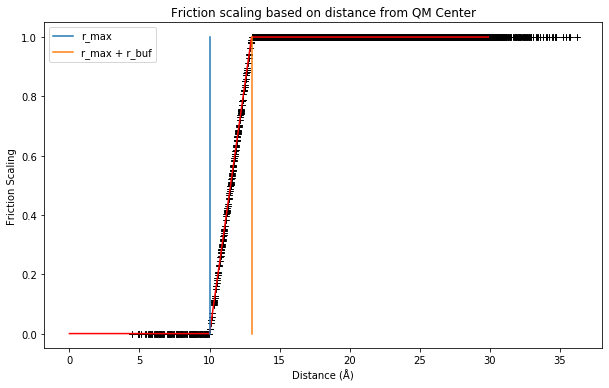

In [21]:
atoms = traj[0]
qmidx = list(range(38))
ctidx = [38, 39, 40, 41]
mmidx = list(range(42, len(atoms)))
r_buf = 3
r_max = 10
fc = 0.1 
apm = 3


fric = np.zeros(len(atoms))
nofric_mask = np.zeros(len(atoms), bool)
nofric_mask[qmidx] = True
mmpos = atoms[mmidx].positions.reshape((-1, apm, 3))  # shape per mol

qmcenter = atoms[qmidx].positions.mean(axis=0)
r, d = find_mic(mmpos[:, 0, :] - qmcenter, atoms.cell, atoms._pbc)  # per water mol
d = np.repeat(d, 3)  # back up to all atom

all_d = np.zeros(len(atoms)) 
all_d[mmidx] = d 



def lin_scale(r, r_max, r_buf):
    factor = (r - r_max) / r_buf
    factor[r > r_max + r_buf] = 1
    factor[r < r_max] = 0
    return factor

# test the scaling 
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(d, lin_scale(d, r_max, r_buf), 'k+')
x = np.arange(0, 30, 0.1)
ax.plot(x, lin_scale(x, r_max, r_buf), 'r')
ax.plot([r_max, r_max], [0, 1], label='r\_max')
ax.plot([r_max + r_buf, r_max + r_buf], [0, 1], label='r\_max + r\_buf')
ax.set_xlabel('Distance (Å)')
ax.set_ylabel('Friction Scaling')
ax.set_title('Friction scaling based on distance from QM Center')
ax.legend(loc='best')

# get scale factor
fac = lin_scale(all_d, r_max, r_buf)

# apply it
fric = fac * fc
# and set everyting above to fc
fric[all_d > r_max + r_buf] = fc 
# and counterions to fc
fric[ctidx] = fc



### Plot only the complex and the waters that are within r_max + r_buf, shade based on friction

Black means NO friction. 


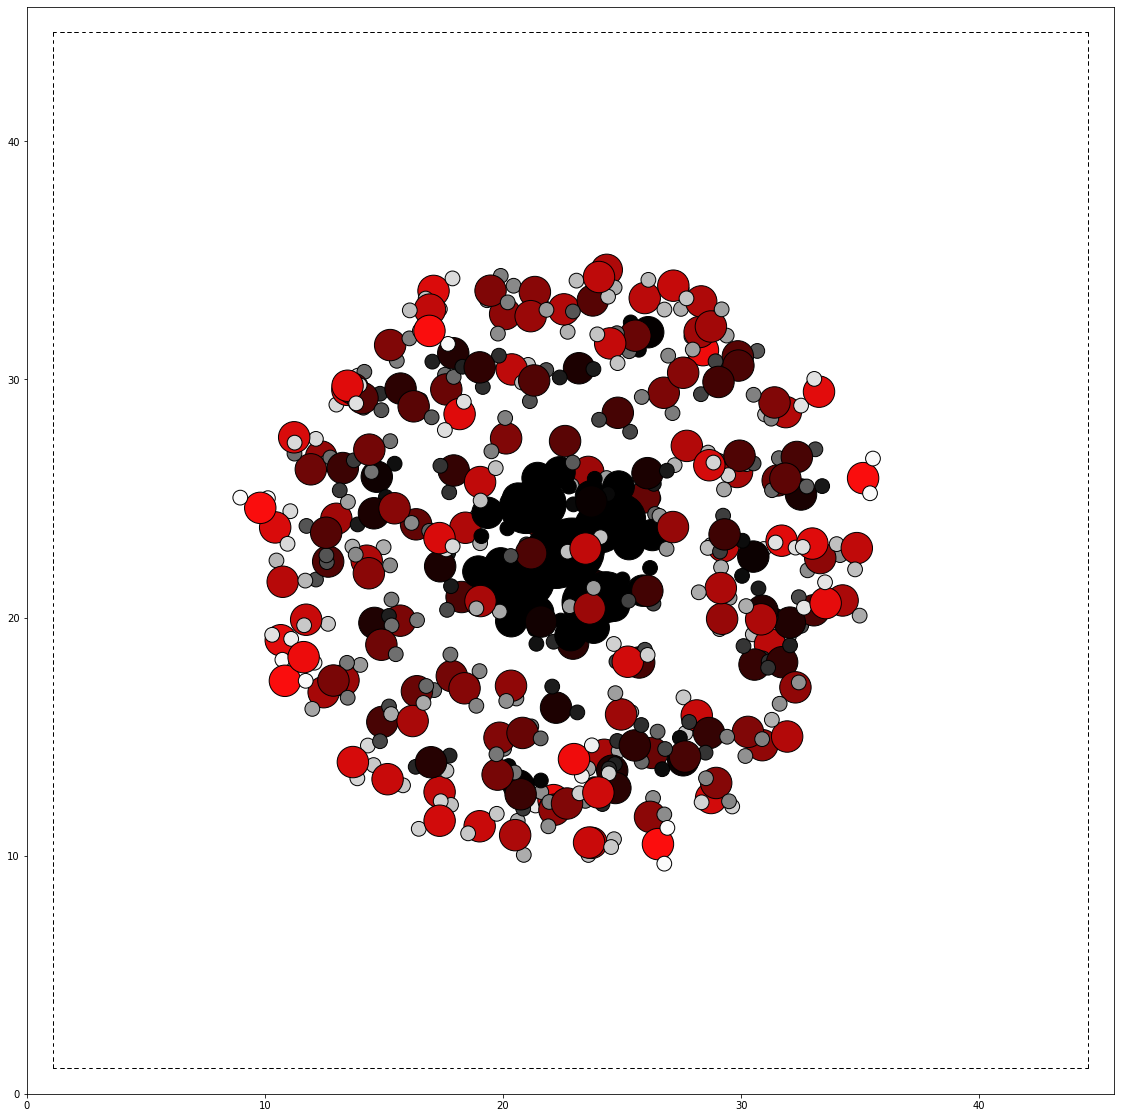

In [22]:
from ase.data.colors import jmol_colors
from ase.visualize.plot import plot_atoms

numbers = atoms.get_atomic_numbers()
colors = jmol_colors[numbers]
colors = [c*f for c, f in zip(colors, fac)]

fig, ax = plt.subplots(1, 1, figsize=(20, 20))
plot_atoms(atoms[qmidx] + atoms[(fric > 0) & (fric < 0.1)], ax, radii=1.0, colors=np.concatenate((np.array(colors)[qmidx], np.array(colors)[(fric > 0) & (fric < 0.1)])))


That looks about right!

### Lets test it

In [67]:
#traj = Trajectory('../../CounterIons/EIQMCombineMM_04_PBC.traj', 'r')
traj = Trajectory('../../CounterIons/NaWater_05_PBC.traj', 'r')
nglview.show_asetraj(traj)
traj[0].cell

Cell([18.636975354596977, 18.636975354596977, 18.636975354596977])

In [69]:
import MDAnalysis as mda
from MDAnalysis.analysis.rdf import InterRDF

u = mda.Universe('../glangevin_tests/rmax5/00.xyz', dt=2e-3)
u.dimensions= np.array([18.636975354596977, 18.636975354596977, 18.636975354596977, 90, 90, 90])

In [70]:
nglview.show_mdanalysis(u)

NGLWidget(max_frame=990)

Sample RDFs and average

In [86]:
rdfs = [[], []]
for a, rmax in enumerate(['rmax5', 'rmax7']):
    xyzs = sorted(glob.glob(f'../glangevin_tests/{rmax}/*.xyz'))
    for xyz in xyzs:
        u = mda.Universe(xyz, dt=2e-3)
        u.dimensions= np.array([18.636975354596977, 18.636975354596977, 18.636975354596977, 90, 90, 90])

        ion = u.select_atoms('index 0')
        owa = u.select_atoms('type O')
        dr = 0.05
        rdf = InterRDF(ion, owa, range=(0, 25), nbins=len(np.arange(0, 25, dr)))
        rdf.run()

        rdfs[a].append(rdf.rdf) 


Aaand also for the ones that have friction everywhere

In [102]:
fc_rdfs = []
xyzs = sorted(glob.glob(f'../glangevin_tests/everywhere/*.xyz'))
for xyz in xyzs:
    u = mda.Universe(xyz, dt=2e-3)
    u.dimensions= np.array([18.636975354596977, 18.636975354596977, 18.636975354596977, 90, 90, 90])

    ion = u.select_atoms('index 0')
    owa = u.select_atoms('type O')
    dr = 0.05
    rdf = InterRDF(ion, owa, range=(0, 25), nbins=len(np.arange(0, 25, dr)))
    rdf.run()

    fc_rdfs.append(rdf.rdf) 


<IPython.core.display.Javascript object>


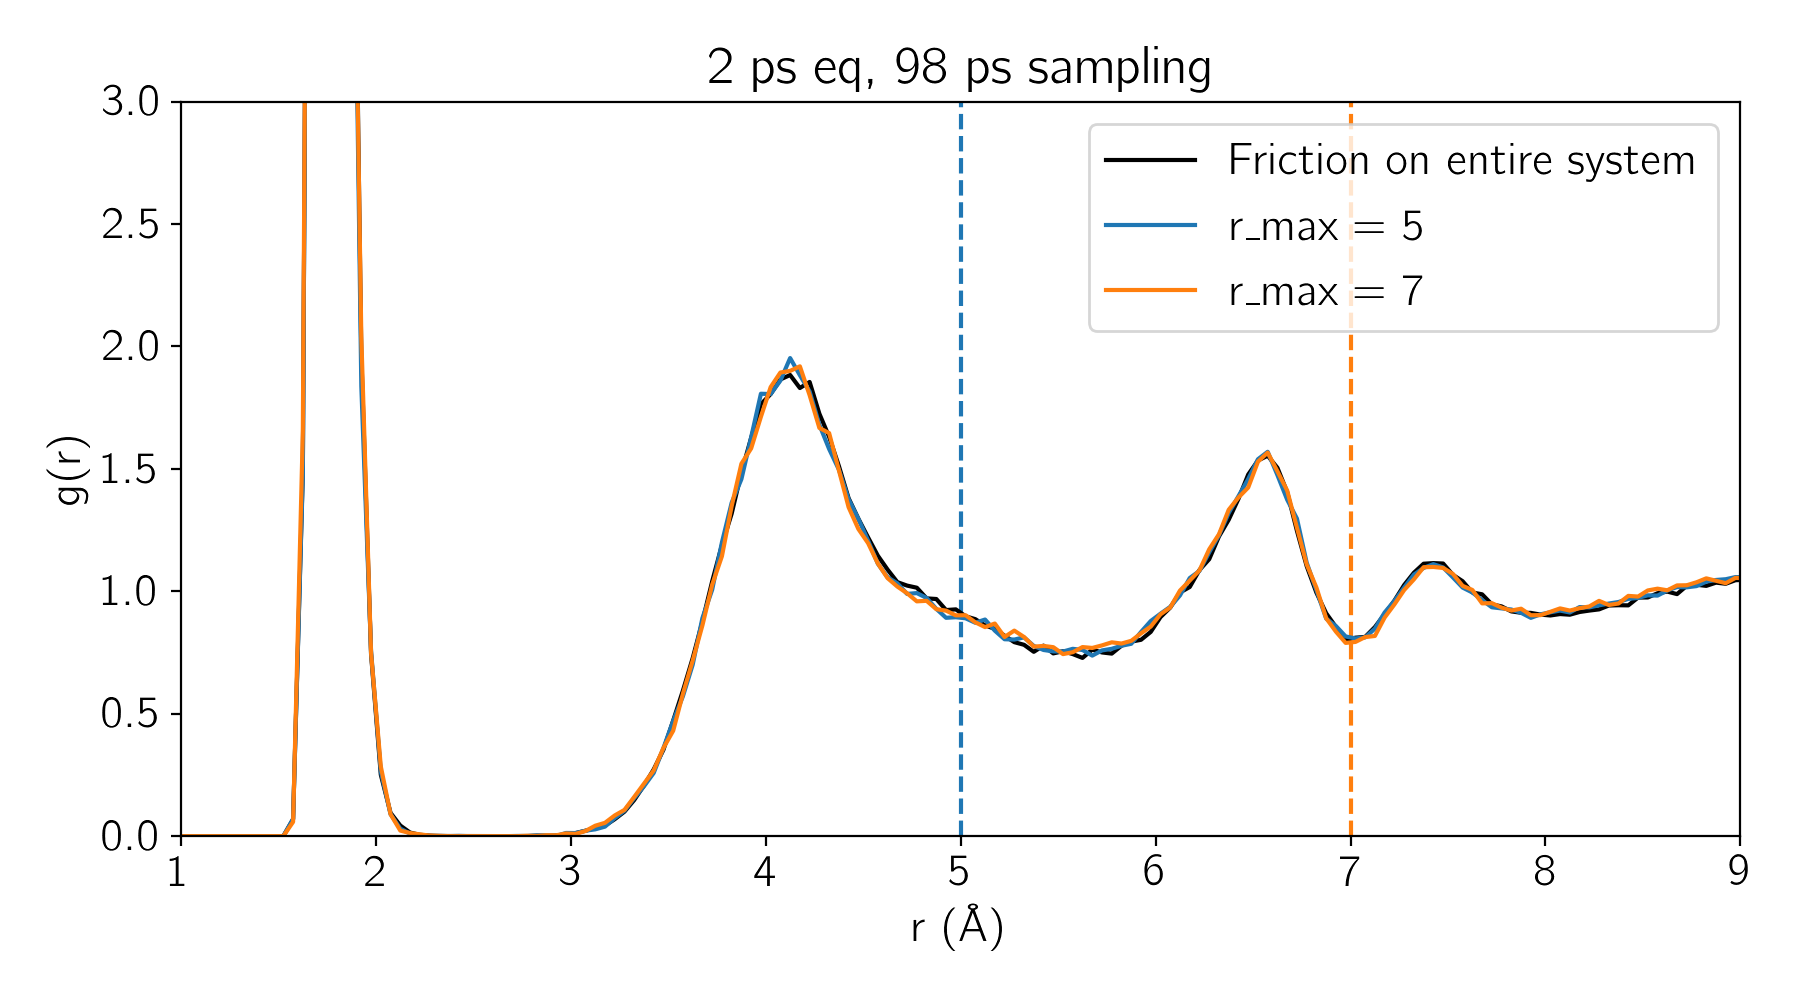

Text(0.5, 1.0, '2 ps eq, 98 ps sampling')

In [104]:
rmax5_avg = np.mean(rdfs[0], axis=0)
rmax7_avg = np.mean(rdfs[1], axis=0)
fc_avg = np.mean(fc_rdfs, axis=0)

fig, ax = plt.subplots(1, 1, figsize=(9, 5))
ax.plot([5, 5], [0, 3], 'C0--')
ax.plot([7, 7], [0, 3], 'C1--')
ax.plot(rdf.bins, fc_avg, 'k', label='Friction on entire system')
ax.plot(rdf.bins, rmax5_avg, 'C0', label='r\_max = 5')
ax.plot(rdf.bins, rmax7_avg, 'C1', label='r\_max = 7')
ax.set_xlim([1, 9])
ax.set_ylim([0, 3])
ax.legend(loc='best')
ax.set_ylabel('g(r)')
ax.set_xlabel('r (Å)')
ax.set_title('2 ps eq, 98 ps sampling');

Check if there is actually enough thermostated atoms left to maintain the temperature. 

This test does NOT translate directly to the QM/MM situation, since the drift here is much much lower, so the thermostat doesn't have to work as hard

<IPython.core.display.Javascript object>


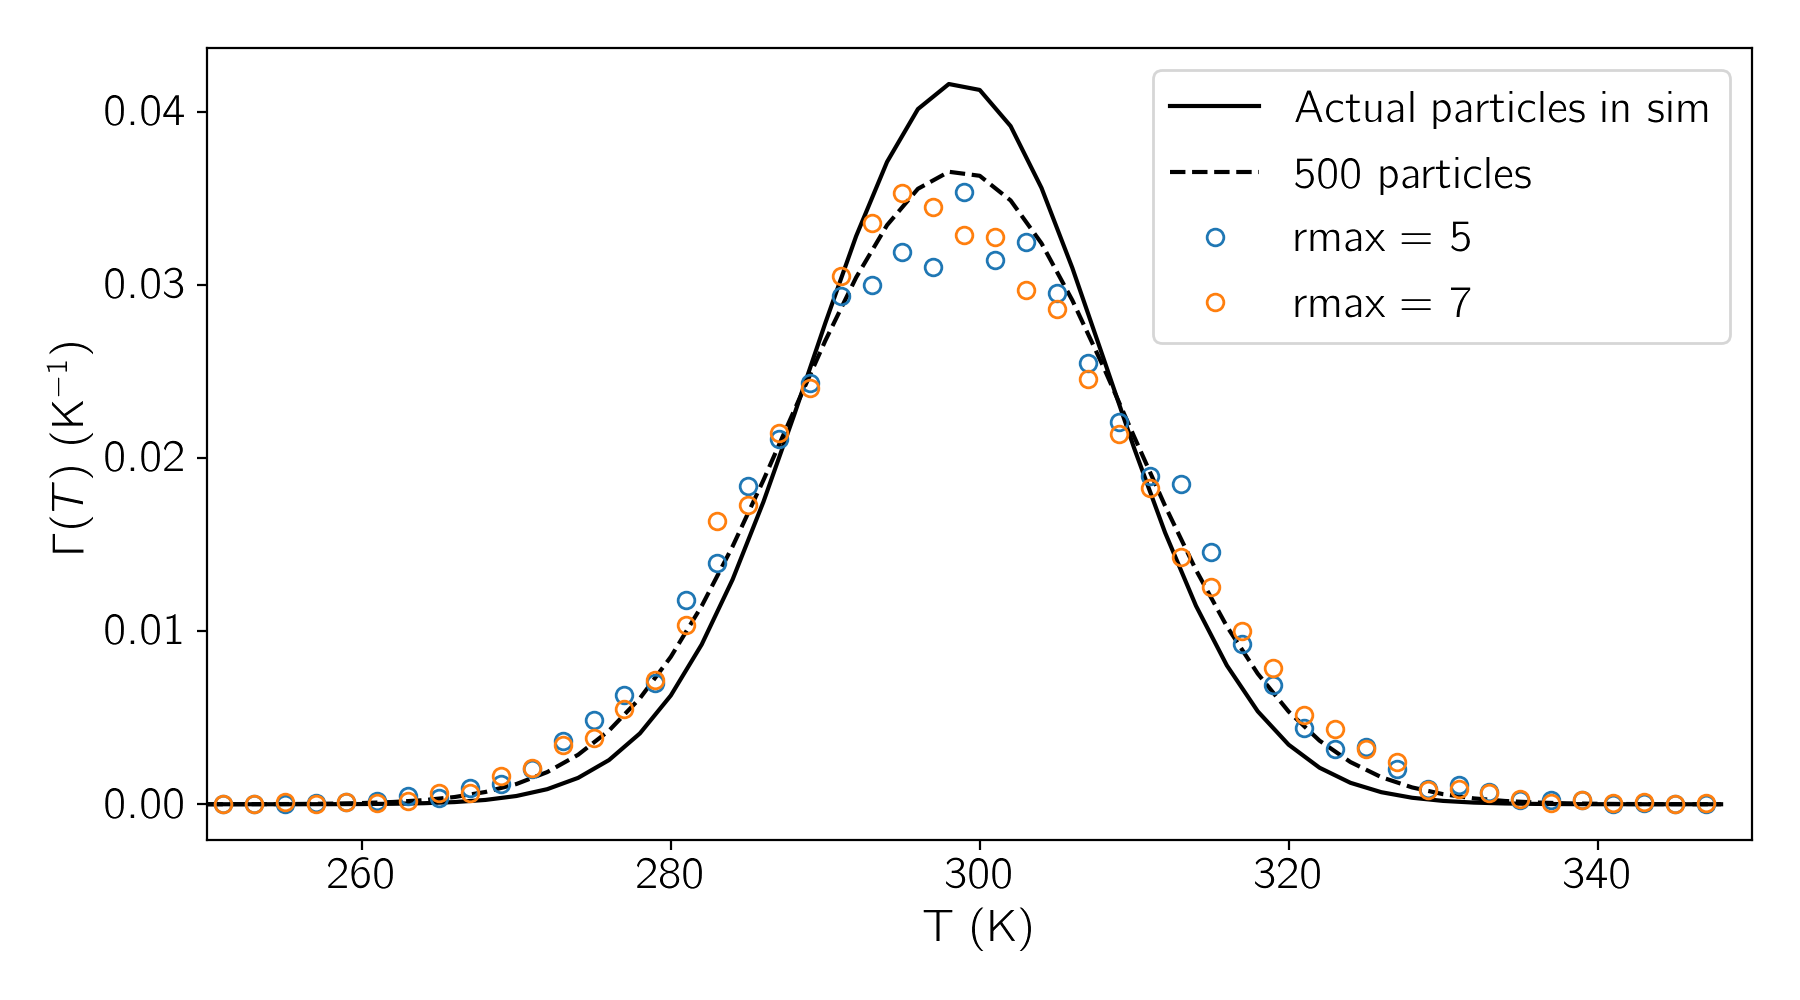

Text(0, 0.5, '$\\Gamma(T)$ (K$^{-1}$)')

In [141]:
rmx5_tmp = np.genfromtxt('../glangevin_tests/rmax5/temps.dat')[:, -2] * 3 / 2  # saved without dof_removed .. 
rmx7_tmp = np.genfromtxt('../glangevin_tests/rmax7/temps.dat')[:, -2] * 3 / 2 



dt = 2
T = np.arange(250, 350, dt)
tmp5, _ = np.histogram(rmx5_tmp, T, density=True)
tmp7, _ = np.histogram(rmx7_tmp, T, density=True)

N = 649  # but maybe 216 waters.. and maybe less since not all see friction
var5 = np.sqrt(2 * np.mean(rmx5_tmp)**2 / (3 * N))

def g(x, sig, avg):
    norm = 1 / (sig * np.sqrt(2 * np.pi))
    return norm * np.exp( -0.5 * ( (x - avg) / sig)**2 )


fig, ax = plt.subplots(1, 1, figsize=(9, 5))
ax.plot(T, g(T, var5, np.mean(rmx5_tmp)), 'k-', label='Actual particles in sim')

N = 500  # but maybe 216 waters.. and maybe less since not all see friction
var5 = np.sqrt(2 * np.mean(rmx5_tmp)**2 / (3 * N))
ax.plot(T, g(T, var5, np.mean(rmx5_tmp)), 'k--', label='500 particles ')

ax.plot(T[1:] - 0.5 * dt, tmp5, 'o', mfc='none', label='rmax = 5')
ax.plot(T[1:] - 0.5 * dt, tmp7, 'o', mfc='none', label='rmax = 7')


ax.legend(loc='best')
ax.set_xlim([250, 350])
ax.set_xlabel('T (K)')
ax.set_ylabel('$\Gamma(T)$ (K$^{-1}$)');